In [24]:
import pandas as pd
import os
from utils_hiv.DRM_utils import *
import seaborn as sns
import matplotlib.pyplot as plt 

# Reading data

In [2]:
os.chdir('/Users/lucblassel/')

In [3]:
dataDir = 'Documents/Work/hiv-drm-detection/data_pre_split'

In [4]:
datasets = ['UK', 'Africa']
paths = {key:os.path.join(dataDir, f'{key}-data-with-scores.tsv.homo') for key in datasets}
metaPaths = {key:os.path.join(dataDir, f'{key}-metadata.tsv') for key in datasets}

In [5]:
datasets = {
    key: pd.read_csv(path, sep='\t', index_col=0)
    for key, path in paths.items()
}

In [6]:
metadata = {
    key: pd.read_csv(path, sep='\t', index_col=0)
    for key, path in metaPaths.items()
}

In [7]:
for key, data in datasets.items():
    data['dataset'] = key
    data['subtype'] = metadata[key].filter(regex=r'.*(s|S)ubtype', axis=1).iloc[:,0].rename('subtype')

In [8]:
totalData = pd.concat(datasets.values(), axis=0)

# Summarizing data

In [9]:
treatment, drm  = ['RTI naive', 'RTI experienced'], ['without DRM(s)', 'with DRM(s)']

In [10]:
pivoted = pd.pivot_table(totalData, index='dataset', columns=['encoded_label', 'hasDRM'], values='subtype', aggfunc=lambda x: len(x))
sizes = pd.Series({k:v.shape[0] for k,v in datasets.items()})
for i , row in pivoted.iterrows(): 
    for j, item in row.iteritems():
        pivoted.loc[i,j] = f"{item} ({(item/sizes.loc[i]) * 100:.0f} %)"
pivoted.columns = pd.MultiIndex.from_product([treatment, drm])

In [21]:
pivoted

RTI naive               RTI experienced             
        without DRM(s)   with DRM(s)  without DRM(s)  with DRM(s)
dataset                                                          
Africa     1998 (50 %)     318 (8 %)       286 (7 %)  1388 (35 %)
UK        30492 (55 %)  11429 (21 %)     6985 (13 %)  6633 (12 %)

In [12]:
# percentage of hasDRM in classes
pd.pivot(totalData.groupby(['dataset', 'encoded_label'])['hasDRM']
    .apply(lambda x: x.value_counts(normalize=True).get(1))
    .apply(lambda x: f"{x * 100:.0f}%")
    .reset_index(), index='dataset', columns='encoded_label', values='hasDRM').rename({i:v for i,v in enumerate(treatment)}, axis=1)


encoded_label,RTI naive,RTI experienced
dataset,,
Africa,14%,83%
UK,27%,49%


## Multiple resistance

In [13]:
totalData['multiDRMs'] = totalData.filter(get_all_DRMs(), axis=1).sum(axis=1)

In [14]:
multiResistant = totalData[totalData['multiDRMs'] > 1].groupby('dataset')['encoded_label'].count()
for i, item in multiResistant.iteritems():
    multiResistant.loc[i] = f"{item} ({(item/sizes.loc[i]) * 100:.0f} %)"

In [15]:
multiResistanceInfo = pd.concat([
    multiResistant.rename('n sequence with>=2 DRMs'),
    totalData[totalData['hasDRM']==1].groupby('dataset')['multiDRMs'].max().rename('max n DRMs'),
    totalData[totalData['hasDRM']==1].groupby('dataset')['multiDRMs'].median().rename('median n DRMs in sequence with DRMs')
], axis=1)
multiResistanceInfo

,n sequence with>=2 DRMs,max n DRMs,median n DRMs in sequence with DRMs
dataset,,,
Africa,1308 (33 %),13,3
UK,8034 (14 %),17,1


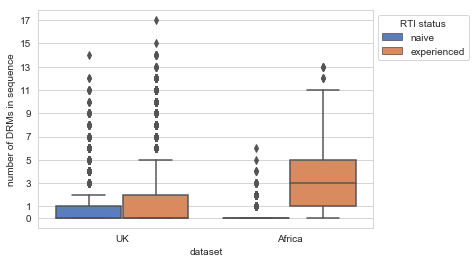

In [25]:
sns.set_style('whitegrid')

to_plot = totalData[['dataset', 'encoded_label', 'multiDRMs']]
to_plot['label'] = to_plot['encoded_label'].apply(lambda x: ['naive', 'experienced'][x])

ax = sns.boxplot(data=to_plot, x='dataset', y='multiDRMs', hue='label', palette='muted')
ax.set_yticks([0, *range(1, 18, 2)])
ax.set_ylabel('number of DRMs in sequence')
plt.legend(bbox_to_anchor=[1,1,0,0], loc='upper left', title='RTI status')

In [29]:
summarize = to_plot.join(
    to_plot['multiDRMs'].apply(lambda x: f"{['no', 'one'][x]} DRM" if x < 2 else "multiple DRMs").rename('class'))
stats = (summarize.groupby(['dataset', 'label'])['class']
    .apply(lambda x: pd.concat([pd.value_counts(x), pd.value_counts(x, normalize=True)]))
)
concated = pd.concat([stats[stats <= 1], stats[stats > 1]], axis=1)
concated.columns = ['freq','count']

formatted = (concated.apply(lambda row: f"{row['count']:g} ({100 * row['freq']:.0f} %)", axis=1)
    .rename('format')
    .reset_index())
pivoted = pd.pivot_table(formatted, values='format', columns='dataset', index=['label', 'level_2'], aggfunc=lambda x:x)

In [30]:
pivoted

dataset                         Africa            UK
label       level_2                                 
experienced multiple DRMs  1249 (75 %)   4127 (30 %)
            no DRM          286 (17 %)   6985 (51 %)
            one DRM          139 (8 %)   2506 (18 %)
naive       multiple DRMs     59 (3 %)    3907 (9 %)
            no DRM         1998 (86 %)  30492 (73 %)
            one DRM         259 (11 %)   7522 (18 %)

## Phylogenetic makeup

In [16]:
subs = totalData[totalData['dataset']=='Africa']['subtype']

In [17]:
print(subs[subs.str.contains('^CRF')].value_counts().shape[0])
subs[subs.str.contains('^CRF')].value_counts()

15


CRF02_AG      1477
CRF06_cpx      278
CRF01_AE       273
CRF11_cpx       84
CRF09_cpx       50
CRF18_cpx       26
CRF25_cpx       13
CRF45_cpx       12
CRF49_cpx       11
CRF13_cpx        9
CRF05_DF         5
CRF22_01A1       4
CRF10_CD         2
CRF37_cpx        1
CRF04_cpx        1
Name: subtype, dtype: int64

In [18]:
print(subs[subs.str.contains('\+')].value_counts().shape[0])
subs[subs.str.contains('\+')].value_counts()

6


A + G           15
A + J            6
G + Unknown      5
G + H + J        4
G + J            4
B + CRF01_AE     1
Name: subtype, dtype: int64

In [19]:
print(subs[subs.str.contains('^\W*[A-Z]+\W*$')].value_counts().shape[0])
subs[subs.str.contains('^\W*[A-Z]+\W*$')].value_counts()

9


C    702
A    472
G    210
D     99
B     64
H     47
J     17
F     15
K     10
Name: subtype, dtype: int64

In [41]:
sub_subset = (totalData.groupby(['dataset'])['subtype'].apply(pd.value_counts).astype(str) + 
totalData.groupby(['dataset'])['subtype'].apply(lambda x: x.value_counts(normalize=True)).apply(lambda x: f" ({x*100:.1f}%)")).loc[
    [(c,s) for c in ['Africa', 'UK'] for s in ['B', 'C', 'A', 'CRF02_AG']]
].dropna()

In [47]:
sub_subset.reset_index().pivot(index='level_1', columns='dataset', values='subtype').fillna('0')

dataset,Africa,UK
level_1,,
A,472 (11.8%),0
B,64 (1.6%),37806 (68.1%)
C,702 (17.6%),17733 (31.9%)
CRF02_AG,1477 (37.0%),0


In [50]:
datasets['UK'].shape

(55539, 1740)